In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import spearmanr

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from nudging.parallel import execute_parallel
from nudging.correlation import smooth_data_2
from nudging.model import BiRegressor, MonoRegressor, XRegressor
from nudging.simulation import generate_datasets
from nudging.evaluate_outcome import evaluate_performance
from utils import get_datasets, get_models, get_cate_outcomes, parameter_descriptions

### Create the datasets

This creates 1000 datasets, where each of them have different parameters for generation. They include both linear and non-linear datasets.

In [2]:
datasets = get_datasets(5000)

In [3]:
results = get_cate_outcomes(datasets)

100%|████████████████████████████████████| 165000/165000 [26:18:29<00:00,  1.74it/s]


### The plot function below creates scatter plots from the data

It does so for one particular meta-learner or regressor. It is basically the cumulative distribution function for the spearmanr/top correlation.

In [4]:
def plot_results(name, results, cate=True):
    plt.figure(dpi=150)
    if cate:
        res_key = "cate_perf"
        res_name = "CATE correlation"
    else:
        res_key = "out_perf"
        res_name = "Outcome correlation"
    plt.title(f"{name}: {res_name}")
    all_data = {}
    if name in learner_dict:
        for model_name in regressors:
            all_data[model_name] = results[model_name][name][res_key]
    else:
        for learner_type in learner_dict:
            all_data[learner_type] = results[name][learner_type][res_key]
            
    sorted_items = sorted(all_data.items(), key=lambda x: np.mean(x[1]), reverse=True)
    for other_name, data in sorted_items:
        plt.scatter(np.arange(len(data)), np.sort(data), label=f"{other_name}: {np.mean(data): .3f}")
    plt.legend(bbox_to_anchor=(1.04,1))
    plt.show()

In [5]:
mean_results = {"cate_perf": {}, "out_perf": {}}
for model_name, model_res in results.items():
    learner_type, regressor_name = model_name.split(" ")
    for perf_type, perf_res in model_res.items():
        name = f"{learner_type} - {model_name}"
        mean_results[perf_type][name] = np.mean(perf_res)

Let's see what the performance is for the different algorithms. We only show the best 15 performing algorithm combinations. 

In [6]:
dict(sorted(mean_results["cate_perf"].items(), key=lambda item: -item[1])[:15])

{'t-learner - t-learner ard': 0.2924713867800734,
 'x-learner - x-learner ard': 0.2922175076428196,
 'x-learner - x-learner ridge': 0.29064005773680845,
 't-learner - t-learner ridge': 0.2905920487054833,
 'x-learner - x-learner linear': 0.29034957280772244,
 't-learner - t-learner linear': 0.29034658020699033,
 't-learner - t-learner bayesian_ridge': 0.2823937221135847,
 'x-learner - x-learner bayesian_ridge': 0.2794139595802816,
 'x-learner - x-learner mlp': 0.2708027389603711,
 't-learner - t-learner mlp': 0.26116351253537246,
 't-learner - t-learner svm': 0.20858918607811697,
 's-learner - s-learner mlp': 0.2061740907753256,
 'x-learner - x-learner svm': 0.19441041804426878,
 'x-learner - x-learner knn': 0.12037274104263618,
 't-learner - t-learner knn': 0.11040406925280331}

In [7]:
dict(sorted(mean_results["out_perf"].items(), key=lambda item: -item[1])[:15])

{'x-learner - x-learner ridge': 0.2136517889084957,
 't-learner - t-learner ridge': 0.21360719819906882,
 't-learner - t-learner ard': 0.21357146901318555,
 'x-learner - x-learner ard': 0.21349762788679394,
 't-learner - t-learner linear': 0.21348201960122287,
 'x-learner - x-learner linear': 0.21348098570291674,
 't-learner - t-learner bayesian_ridge': 0.2130888451732082,
 'x-learner - x-learner bayesian_ridge': 0.21291219171341214,
 's-learner - s-learner mlp': 0.20296184996564925,
 'x-learner - x-learner mlp': 0.19945985106027564,
 't-learner - t-learner mlp': 0.19869326931422338,
 's-learner - s-learner ridge': 0.19801790125161198,
 's-learner - s-learner linear': 0.19797964670310925,
 's-learner - s-learner ard': 0.1966279995209111,
 's-learner - s-learner bayesian_ridge': 0.19473513081790883}

We already know that the t-learner and x-learner are very similar in performance. The s-learner (single regressor) is way worse for almost all of the models. The top 3 regressors are `ard`, `linear` and `ridge`, which have almost the same performance. `bayesian_ridge` is a good 4th.

The function below can plot the dependencies of the correlations as a function of the parameters used for the dataset. This is useful, since we can then more easily understand in which situations models perform better/worse compared to each other.

In [8]:
def plot_dependencies(attr, name, n_data=50, cate=True):
    plt.figure(dpi=150)
    if cate:
        res_key = "cate_perf"
        res_name = "CATE"
    else:
        res_key = "out_perf"
        res_name = "Outcome"
    plt.title(f"{name}: {res_name}")
    all_data = {model_name: res[res_key] for model_name, res in results.items() if name in model_name}
 
    sorted_items = sorted(all_data.items(), key=lambda x: np.mean(x[1]), reverse=True)
    x = np.array([d.truth[attr] for d in datasets])
    for other_name, raw_data in sorted_items:
        k = len(raw_data)//len(x)
        data =  np.array([np.mean(raw_data[i*k: (i+1)*k]) for i in range(len(x))])
        xy_corr = spearmanr(x, data).correlation
        x_smooth, y_smooth = smooth_data_2(x, data, n_data=n_data)
        plt.plot(x_smooth, y_smooth, label=f"{other_name}: {xy_corr: .3f}")
    plt.xlabel(parameter_descriptions()[attr])
    plt.ylabel("correlation / performance")
    plt.legend(bbox_to_anchor=(1.04,1))
    plt.show()

The plot below shows the parameter `noise_frac`, which tells us how much noise is added to the system. As expected, more noise means worse results for the determination of the cate.The top performers have very similar behavior in this regard.

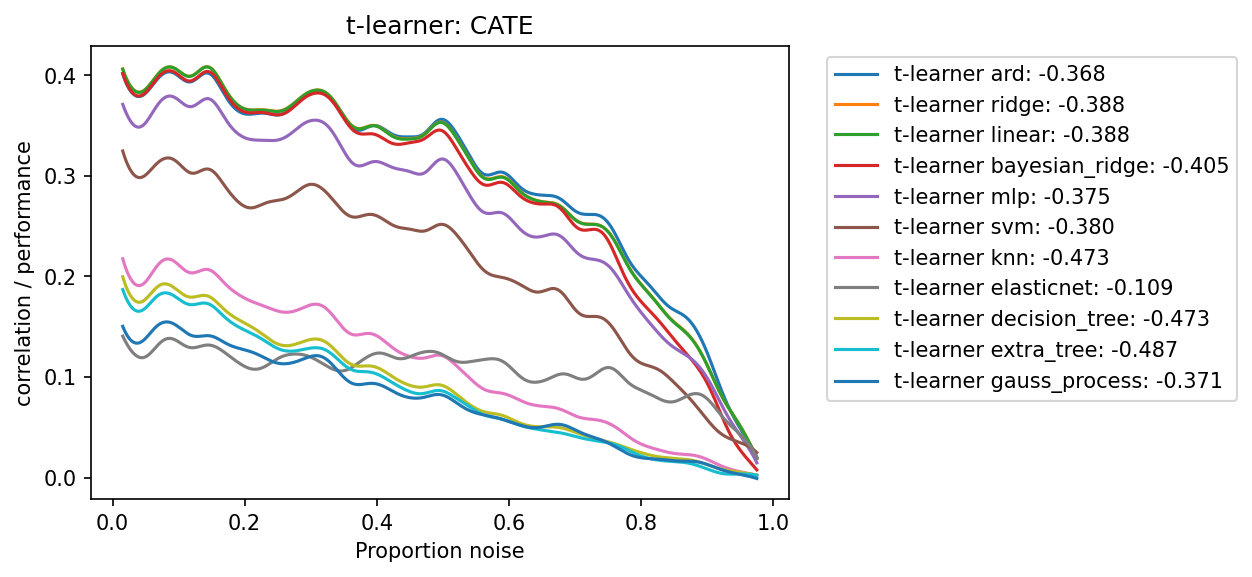

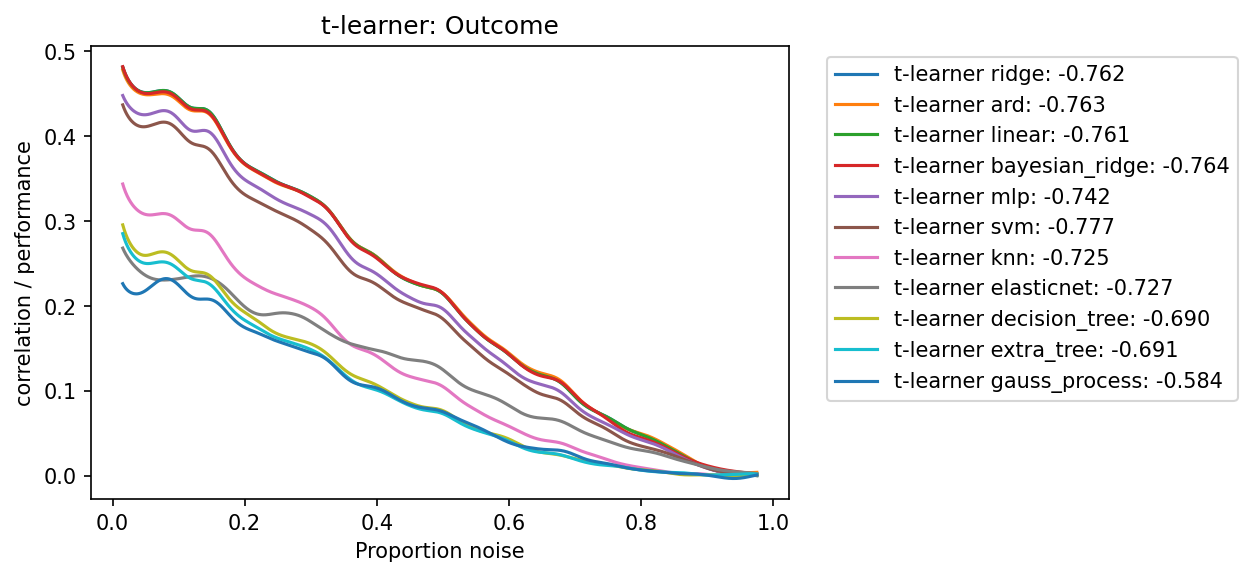

In [9]:
plot_dependencies("noise_frac", "t-learner", n_data=50)
plot_dependencies("noise_frac", "t-learner", n_data=50, cate=False)

We do the same for the number of samples. As expected, the higher the number of samples, the better the inference of the CATE. Interestingly the neural network `mlp` has a stronger correlation to the number of samples than the other good regressors, which reinforces the notion that indeed neural networks are very data hungry.

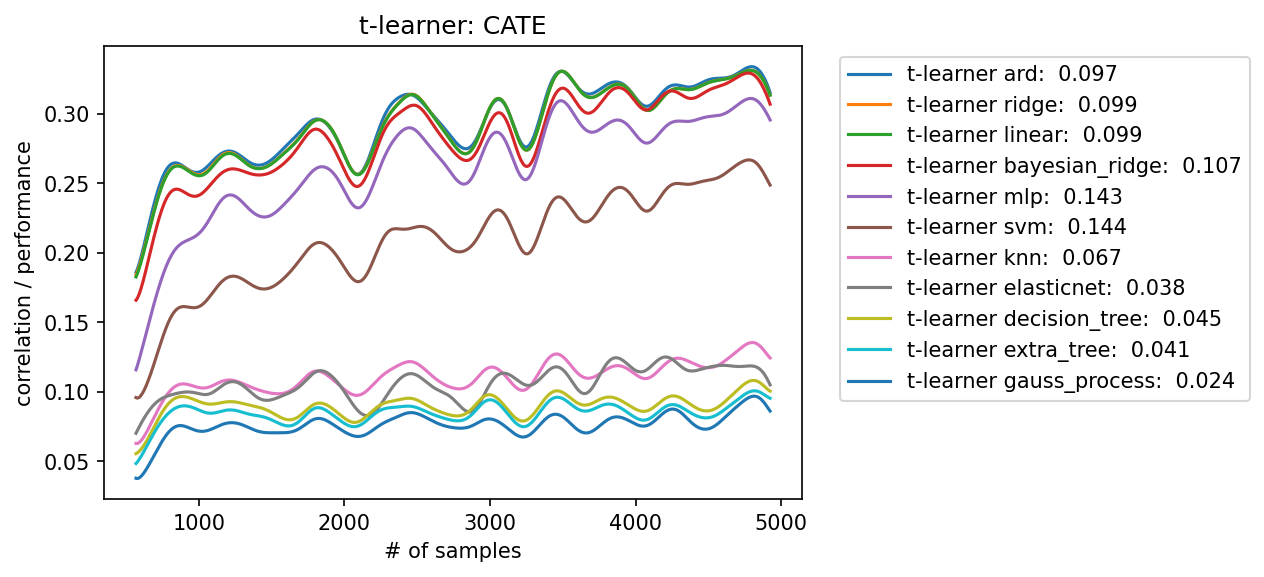

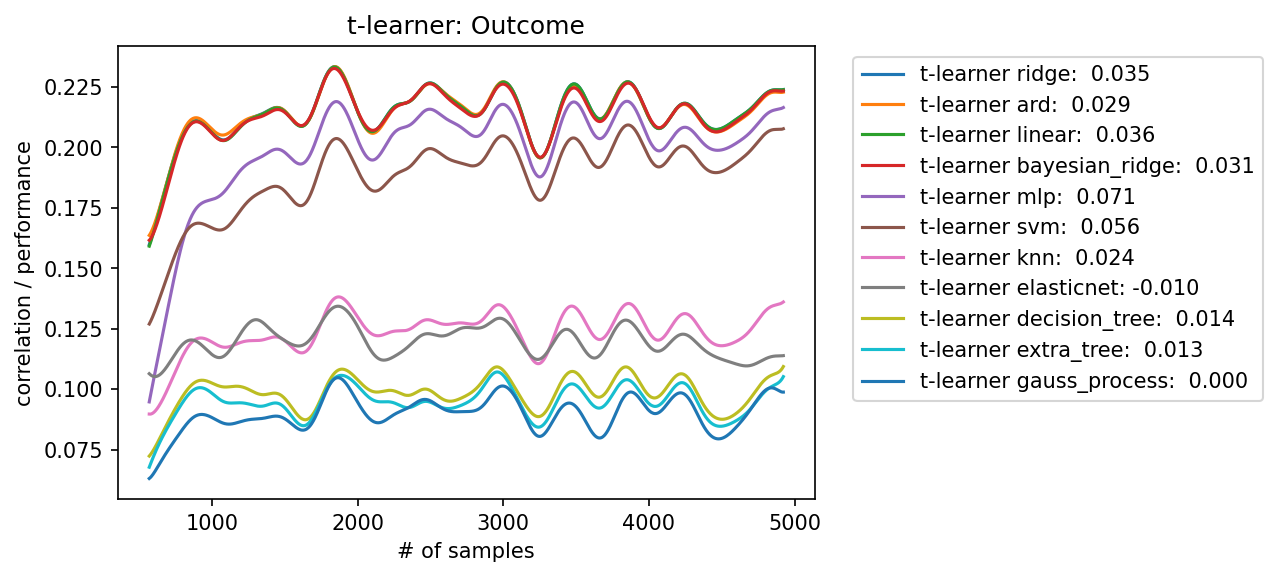

In [10]:
plot_dependencies("n_samples", "t-learner", n_data=50)
plot_dependencies("n_samples", "t-learner", n_data=50, cate=False)